# Line-sample Opacity Tutorial
This tutorial shows how to create a line-sample opacity object and compute extinction coefficient spectra for a given atmospheric profile.

As inputs for this demo we will use the tabulated cross sections for H2O and CO from HITRAN/HITEMP.  To generate these inputs, run the script in [Sample HITRAN/HITEMP line lists](https://pyratbay.readthedocs.io/en/latest/cookbooks/line_list_hitran.html) so that you have the following files in your current directory:

- cross_section_R020K_0150-3000K_0.5-5.0um_hitemp_H2O.npz
- cross_section_R020K_0150-3000K_0.5-5.0um_hitemp_CO.npz

Lets start by importing some necessary modules:

In [1]:
import pyratbay.opacity as op
import pyratbay.atmosphere as pa
import pyratbay.constants as pc

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load up HITRAN H2O and CO line-sampling opacities:
cs_files = [
    'cross_section_R020K_0150-3000K_0.5-5.0um_hitran_H2O.npz',
    'cross_section_R020K_0150-3000K_0.5-5.0um_hitemp_CO.npz',
]
# Initialize line-sample object:
line_sample = op.Line_Sample(cs_files)

# Convenience arrays:
wl = line_sample.get_wl('um')
pressure = line_sample.press/pc.bar

In [3]:
# A print() call shows some useful info about the object:
print(line_sample)

Line-sampling cross-section files (cs_files):
['cross_section_R020K_0150-3000K_0.5-5.0um_hitran_H2O.npz',
    'cross_section_R020K_0150-3000K_0.5-5.0um_hitemp_CO.npz']
Number of species (nspec): 2
Number of temperature samples (ntemp): 20
Number of pressure layers (nlayers): 51
Number of wavenumber samples (nwave): 46052

Minimum and maximum temperatures (tmin, tmax) in K: [150.0, 3000.0]
Minimum and maximum pressures in bar: [1.000e-08, 1.000e+02]
Minimum and maximum wavelengths in um: [0.500, 5.000]

Line-sample species (species): ['H2O' 'CO']
Temperature array (temps, K):
[ 150.  300.  450.  600.  750.  900. 1050. 1200. 1350. 1500. 1650. 1800.
 1950. 2100. 2250. 2400. 2550. 2700. 2850. 3000.]
Pressure layers (pressure, barye):
[1.000e-02 1.585e-02 2.512e-02 3.981e-02 6.310e-02 1.000e-01 1.585e-01
 2.512e-01 3.981e-01 6.310e-01 1.000e+00 1.585e+00 2.512e+00 3.981e+00
 6.310e+00 1.000e+01 1.585e+01 2.512e+01 3.981e+01 6.310e+01 1.000e+02
 1.585e+02 2.512e+02 3.981e+02 6.310e+02 1.000e

## Compute spectra
Lets compute some cross-section and extinction coefficients for an atmosphere model:

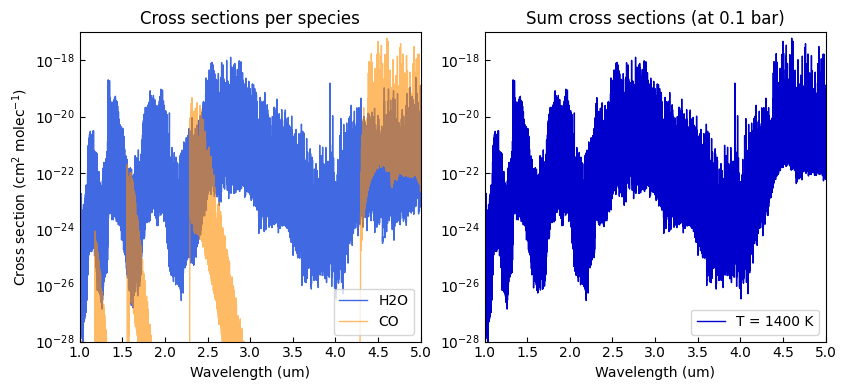

In [4]:
# Calculate cross sections:
temperature = np.tile(1400.0, line_sample.nlayers)
cross_section = line_sample.calc_cross_section(temperature)

# Set the flag per_mol=True to request cross sections per molecule:
cs_per_mol = line_sample.calc_cross_section(temperature, per_mol=True)


# Show cross sections at this layer (0.1 bar):
i_press = 35

plt.figure(1, (8.5, 4.0))
plt.clf()
ax = plt.subplot(121)
ax.plot(wl, cs_per_mol[0,i_press], color='royalblue', lw=1.0, label='H2O')
ax.plot(wl, cs_per_mol[1,i_press], color='darkorange', lw=1.0, label='CO', alpha=0.6)
ax.set_yscale('log')
ax.set_ylabel('Cross section (cm$^{2}$ molec$^{-1}$)')
ax.set_xlabel('Wavelength (um)')
ax.set_xlim(1.0, 5.0)
ax.set_ylim(1e-28, 1e-17)
ax.tick_params(which='both', direction='in')
ax.set_title('Cross sections per species')
ax.legend(loc='lower right')

ax = plt.subplot(122)
ax.plot(wl, cross_section[i_press], color='mediumblue', lw=1.0, label='T = 1400 K')
ax.set_yscale('log')
ax.set_xlabel('Wavelength (um)')
ax.set_xlim(1.0, 5.0)
ax.set_ylim(1e-28, 1e-17)
ax.tick_params(which='both', direction='in')
ax.set_title(f'Sum cross sections (at {pressure[i_press]} bar)')
ax.legend(loc='lower right')
plt.tight_layout()


Compute chemical abundances.


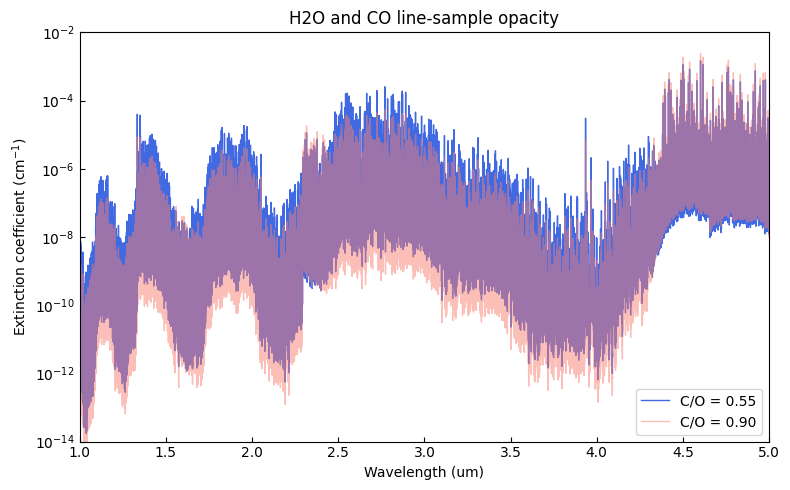

In [5]:
# Likewise, we can calculate extinction coefficients by providing a
# temperature and number density profile:

# Consider a simplified solar-abundance isothermal atmosphere
temperature = np.tile(1400.0, line_sample.nlayers)
species = ['H2', 'H', 'He', 'H2O', 'CO', 'CO2', 'CH4']
chemistry = pa.chemistry('tea', pressure, temperature, species)

# Equilibrium abundances for solar and super-solar C/O ratios:
vmr_solar = chemistry.thermochemical_equilibrium(e_ratio={'C_O': 0.55})
vmr_super = chemistry.thermochemical_equilibrium(e_ratio={'C_O': 0.9})

# Number-density profiles under IGL (molecules per cm3)
densities_solar = pa.ideal_gas_density(vmr_solar, line_sample.press, temperature)
densities_super = pa.ideal_gas_density(vmr_super, line_sample.press, temperature)

# Indices for line-sample species in the atmosphere:
i_mol = [species.index(mol) for mol in line_sample.species]


# Compute extinction:
extinction_solar = line_sample.calc_extinction_coefficient(
    temperature, densities_solar[:,i_mol],
)
extinction_super = line_sample.calc_extinction_coefficient(
    temperature, densities_super[:,i_mol],
)

plt.figure(2, (8,5))
plt.clf()
ax = plt.subplot(111)
ax.plot(wl, extinction_solar[i_press], color='royalblue', lw=1.0, label='C/O = 0.55')
ax.plot(wl, extinction_super[i_press], color='salmon', lw=1.0, label='C/O = 0.90', alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel('Wavelength (um)')
ax.set_xlim(1.0, 5.0)
ax.set_ylim(1.0e-14, 1e-2)
ax.tick_params(which='both', direction='in')
ax.set_ylabel('Extinction coefficient (cm$^{-1}$)')
ax.legend(loc='lower right')
ax.set_title('H2O and CO line-sample opacity')
plt.tight_layout()

## Customize cross-section grid

In [6]:
# On initialization the user can set the wavelength boundaries
# E.g., to take only wavelengths between 1.0--4.0 micron:

cs_files = 'cross_section_R020K_0150-3000K_0.5-5.0um_hitran_H2O.npz'
line_sample_wl = op.Line_Sample(cs_files, min_wl=1.0, max_wl=4.0)

In [7]:
# Also, it's possible to redefine the pressure array:
custom_press = pa.pressure('1e-9 bar', '1e2 bar', nlayers=101)
line_sample_p = op.Line_Sample(cs_files, pressure=custom_press)

# Note it's allowed to extrapolate to lower pressures than those from the
# input table (assuming Doppler broadening dominates over Pressure broadening)

# But! it is not possible to extrapolate to higher pressures, because that
# requires a pressure broadening calculation, which needs to know the pressures